In [1]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions
from Bio.PDB.Polypeptide import one_to_three
from Bio.PDB.Polypeptide import three_to_one
from Bio.PDB.PDBParser import PDBParser
from pyCodeLib import *
from small_script.myFunctions import *
from collections import defaultdict
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = [16.18033, 10]    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})

In [66]:
def get_two_part_from_eye_seperation(pdb, data):
    row = data.query(f"Protein == '{pdb}'")
    assert len(row) == 1
    row = row.iloc[0]
    glob_start, glob_end = row["Range"].split("-")
    length = row["Length"]
    glob_start = int(glob_start)
    glob_end = int(glob_end)
    print(pdb, glob_start, glob_end)
    GlobularPart = list(range(glob_start, glob_end+1))
    MembranePart = []
    for i in range(1, length+1):
        if i not in GlobularPart:
            MembranePart.append(i)
    return GlobularPart, MembranePart


def get_contactFromDMP(fileLocation, n, threshold=0.5):
    a = np.zeros((n,n))
    c_list = []
    with open(fileLocation, "r") as f:
    #     for i in range(9):
    #         next(f)
        for line in f:
    #         print(line)
            try:
                i,j,_,_,_,p = line.split(" ")
    #             print(i,j,p)
                a[int(i)-1,int(j)-1] = float(p)
                a[int(j)-1,int(i)-1] = float(p)
                if float(p) > threshold:
                    c_list.append([int(i)-1,int(j)-1,float(p)])
            except Exception as e:
                print(e)
                pass
    return a, np.array(c_list)

from Bio.PDB.PDBParser import PDBParser
def getContactMapFromPDB(pdbFile):
    cutoff = 9.5
    MAX_OFFSET = 6
    parser = PDBParser()
    structure = parser.get_structure('target', pdbFile)
    all_residues = list(structure.get_residues())
    
    tmp = []
    for res in all_residues:
        # print(res.id)
        if res.id[0] == ' ':
            tmp.append(res)

    all_residues = tmp

    n = len(all_residues)
    contact_table = np.zeros((n,n))
    # print(all_residues, n)
    for i, res1 in enumerate(all_residues):
        for j, res2 in enumerate(all_residues):
            contact_table[i][j] = res1["CA"]-res2["CA"]

    data = (contact_table < cutoff)
    remove_band = np.eye(n)
    for i in range(1, MAX_OFFSET):
        remove_band += np.eye(n, k=i)
        remove_band += np.eye(n, k=-i)
    data[remove_band==1] = 0
    return data

In [115]:
pdb_list = ["2xov_complete", "6e67A", "5xpd", "3kp9", "4a2n", "5d91", "4nv6", "4p79", "5dsg", "6g7o", "6a93", "2jo1", "1py6", "1pv6", "1u19"]
infoLocation = "/Users/weilu/Research/database/hybrid_prediction_database/length_info.csv"
info = pd.read_csv(infoLocation, index_col=0)
# get_two_part_from_eye
part_info = pd.read_csv("/Users/weilu/Research/database/hybrid_prediction_database/part_info.csv", names=["Protein", "Range"])
part_info = part_info.merge(info, on="Protein")

In [39]:
part_info
pdb = pdb_list[0]
GlobularPart, MembranePart = get_two_part_from_eye_seperation(pdb, part_info)

2xov_complete 1 63


In [47]:

def getSeqFromFasta(fastaFile):
    with open(fastaFile) as f:
        a = f.readlines()
    seq = ""
    for line in a:
        if line[0] == ">":
            continue
        seq += line.strip()
    return seq


In [116]:
import textwrap
for pdb in pdb_list:
    fastaFile = f"/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/setup/{pdb}/{pdb}.fasta"
    seq = getSeqFromFasta(fastaFile)
    GlobularPart, MembranePart = get_two_part_from_eye_seperation(pdb, part_info)
    GlobularPart_index = (np.array(GlobularPart)-1).astype(int)
    MembranePart_index = (np.array(MembranePart)-1).astype(int)
    MembranePart_fastaFile = f"/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/domain_contact_prediction/{pdb}_MembranePart.fasta"
    GlobularPart_fastaFile = f"/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/domain_contact_prediction/{pdb}_GlobularPart.fasta"
    GlobularPart_seq = "".join(np.array(list(seq))[GlobularPart_index])
    MembranePart_seq = "".join(np.array(list(seq))[MembranePart_index])
    with open(MembranePart_fastaFile, "w") as out:
        out.write(f">{pdb}_MembranePart:A\n")
        out.write("\n".join(textwrap.wrap(MembranePart_seq, width=80))+"\n")
    with open(GlobularPart_fastaFile, "w") as out:
        out.write(f">{pdb}_GlobularPart:A\n")
        out.write("\n".join(textwrap.wrap(GlobularPart_seq, width=80))+"\n")


2xov_complete 1 63
6e67A 201 380
5xpd 218 269
3kp9 165 259
4a2n 101 125
5d91 1 131
4nv6 167 264
4p79 31 61
5dsg 205 311
6g7o 245 350
6a93 196 284
2jo1 45 72
1py6 60 75
1pv6 190 219
1u19 310 348


In [19]:
len(seq)

417

In [58]:
# combine contact map.
# and convert into input for simulation.

In [86]:

# pdb = "4nv6"
# fastaFile = f"/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/setup/{pdb}/{pdb}.fasta"
# seq = getSeqFromFasta(fastaFile)
# GlobularPart, MembranePart = get_two_part_from_eye_seperation(pdb, part_info)
# GlobularPart_index = (np.array(GlobularPart)-1).astype(int)
# MembranePart_index = (np.array(MembranePart)-1).astype(int)
# pre = "/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/domain_contact_prediction/"
# fileLocation = f"{pre}/{pdb}_MembranePart.deepmetapsicov.con"
# n = len(MembranePart)
# MembranePart_data = get_contactFromDMP(fileLocation, n)
# MembranePart_fastaFile = f"/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/domain_contact_prediction/{pdb}_MembranePart.fasta"
# seq_MembranePart = getSeqFromFasta(MembranePart_fastaFile)


# fileLocation = f"{pre}/{pdb}_GlobularPart.deepmetapsicov.con"
# n = len(GlobularPart)
# GlobularPart_data = get_contactFromDMP(fileLocation, n)
# GlobularPart_fastaFile = f"/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/domain_contact_prediction/{pdb}_GlobularPart.fasta"
# seq_GlobularPart = getSeqFromFasta(GlobularPart_fastaFile)

4nv6 167 258


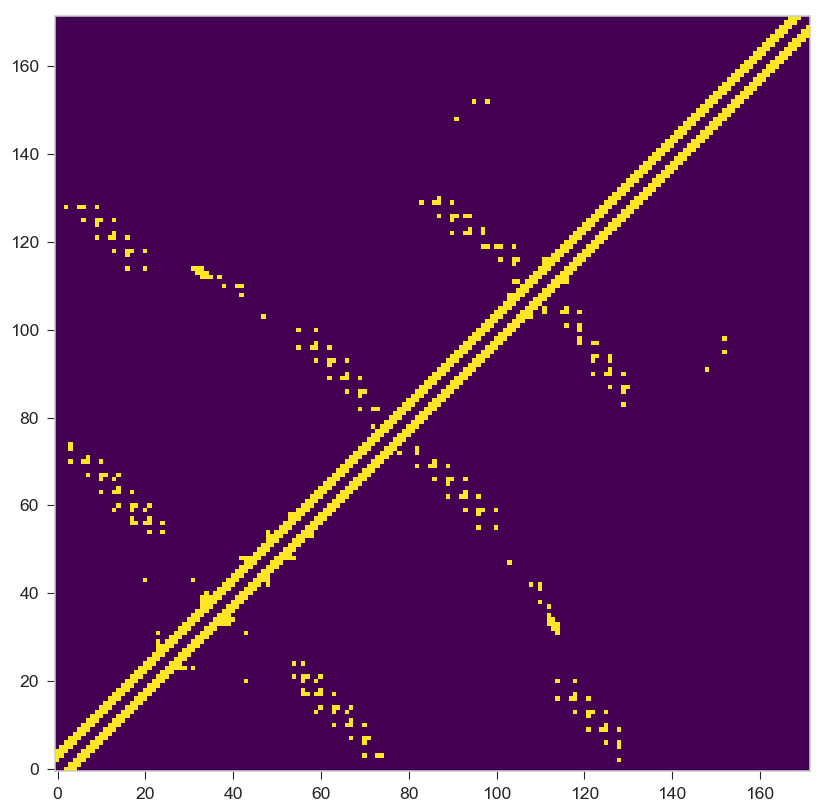

In [104]:
plt.imshow(MembranePart_data[0] > 0.5, origin=0)

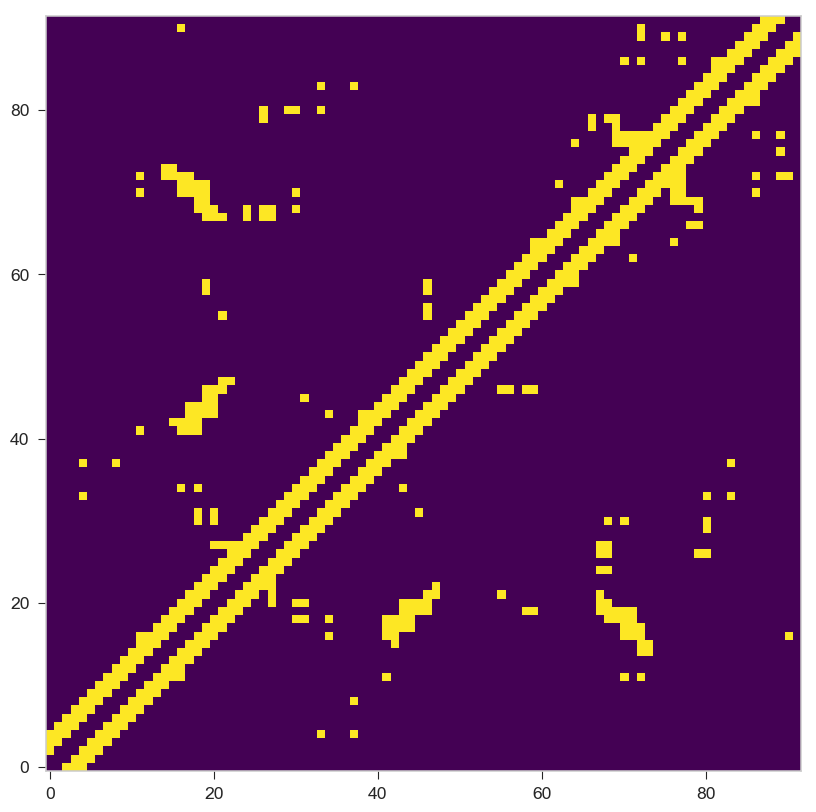

In [103]:
plt.imshow(GlobularPart_data[0] > 0.5, origin=0)

6e67A 201 380


In [119]:
# pdb = "4nv6"
pdb = "6e67A"
fastaFile = f"/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/setup/{pdb}/{pdb}.fasta"
seq = getSeqFromFasta(fastaFile)
GlobularPart, MembranePart = get_two_part_from_eye_seperation(pdb, part_info)
GlobularPart_index = (np.array(GlobularPart)-1).astype(int)
MembranePart_index = (np.array(MembranePart)-1).astype(int)

pre = "/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/domain_contact_prediction/"
fileLocation = f"{pre}/{pdb}_MembranePart.deepmetapsicov.con"
data = pd.read_csv(fileLocation, sep="\s+", names=["i","j","s", "ss","p"]).dropna().reset_index(drop=True)
data["i"] = data["i"].astype(int)
data["j"] = data["j"].astype(int)
data["i"] = data["i"].apply(lambda x:MembranePart_index[x-1]+1)
data["j"] = data["j"].apply(lambda x:MembranePart_index[x-1]+1)
MembranePart_data = data
MembranePart_fastaFile = f"/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/domain_contact_prediction/{pdb}_MembranePart.fasta"
seq_MembranePart = getSeqFromFasta(MembranePart_fastaFile)


fileLocation = f"{pre}/{pdb}_GlobularPart.deepmetapsicov.con"
data = pd.read_csv(fileLocation, sep="\s+", names=["i","j","s", "ss","p"]).dropna().reset_index(drop=True)
data["i"] = data["i"].astype(int)
data["j"] = data["j"].astype(int)
data["i"] = data["i"].apply(lambda x:GlobularPart_index[x-1]+1)
data["j"] = data["j"].apply(lambda x:GlobularPart_index[x-1]+1)
GlobularPart_data = data
GlobularPart_fastaFile = f"/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/domain_contact_prediction/{pdb}_GlobularPart.fasta"
seq_GlobularPart = getSeqFromFasta(GlobularPart_fastaFile)

In [120]:
data = pd.concat([GlobularPart_data, MembranePart_data]).reset_index(drop=True)
# data = pd.concat([MembranePart_data]).reset_index(drop=True)

In [127]:
pre='/Users/weilu/opt/gremlin/'
directory=pre
distancesCACB=pd.read_csv(directory+'CACBmediandist.dat', delim_whitespace=True, header=None)
distancesCACA=pd.read_csv(directory+'CACAmediandist.dat', delim_whitespace=True, header=None)
distancesCBCB=pd.read_csv(directory+'CBCBmediandist.dat', delim_whitespace=True, header=None)
distancesCACB.columns = ['i', 'j', 'dist']
distancesCACA.columns = ['i', 'j', 'dist']
distancesCBCB.columns = ['i', 'j', 'dist']
# if you want to filter the gremlin data, adjust the parameters below
filter_threshold=0.5

In [132]:
column=2
n=len(seq)
#     print(n)
rnative_matrixCACB=np.ones([n,n])*99
rnative_matrixCACA=np.ones([n,n])*99
rnative_matrixCBCB=np.ones([n,n])*99
for _, line in data.iterrows():
    i = int(line["i"])
    j = int(line["j"])
    irestype=seq[i-1]
    jrestype=seq[j-1]
    if line["p"] > filter_threshold:
        if sum((distancesCACB['i']==irestype)&(distancesCACB['j']==jrestype))>0: #check if pair is in correct order
            well_centerCACB = distancesCACB[(distancesCACB['i']==irestype)&(distancesCACB['j']==jrestype)]['dist'].values[0]
            well_centerCACA = distancesCACA[(distancesCACA['i']==irestype)&(distancesCACA['j']==jrestype)]['dist'].values[0]
            well_centerCBCB = distancesCBCB[(distancesCBCB['i']==irestype)&(distancesCBCB['j']==jrestype)]['dist'].values[0]
        else:
            well_centerCACB = distancesCACB[(distancesCACB['i']==jrestype)&(distancesCACB['j']==irestype)]['dist'].values[0]
            well_centerCACA = distancesCACA[(distancesCACA['i']==jrestype)&(distancesCACA['j']==irestype)]['dist'].values[0]
            well_centerCBCB = distancesCBCB[(distancesCBCB['i']==jrestype)&(distancesCBCB['j']==irestype)]['dist'].values[0]

        rnative_matrixCACB[i-1, j-1] = well_centerCACB
        rnative_matrixCACB[j-1, i-1] = well_centerCACB
        rnative_matrixCACA[i-1, j-1] = well_centerCACA
        rnative_matrixCACA[j-1, i-1] = well_centerCACA
        rnative_matrixCBCB[i-1, j-1] = well_centerCBCB
        rnative_matrixCBCB[j-1, i-1] = well_centerCBCB
# import matplotlib.pyplot as plt
pre = "/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/domain_contact_prediction/"
directory = f"{pre}/protein/{pdb}/DMP/"
os.system(f"mkdir -p {directory}")
# plt.imshow(rnative_matrixCACB, origin=0)
np.savetxt(directory + 'go_rnativeCACB.dat', rnative_matrixCACB, fmt='%10.5f')
np.savetxt(directory + 'go_rnativeCACA.dat', rnative_matrixCACA, fmt='%10.5f')
np.savetxt(directory + 'go_rnativeCBCB.dat', rnative_matrixCBCB, fmt='%10.5f')

In [131]:
pre

'/Users/weilu/opt/gremlin/'

In [121]:
n = len(seq)
contact_map = np.zeros((n,n))
for _, line in data.iterrows():
    i = int(line["i"])
    j = int(line["j"])
    irestype=seq[i-1]
    jrestype=seq[j-1]
    n = len(seq)
    if line["p"] > 0.5:
        contact_map[i-1][j-1] = 1
        contact_map[j-1][i-1] = 1

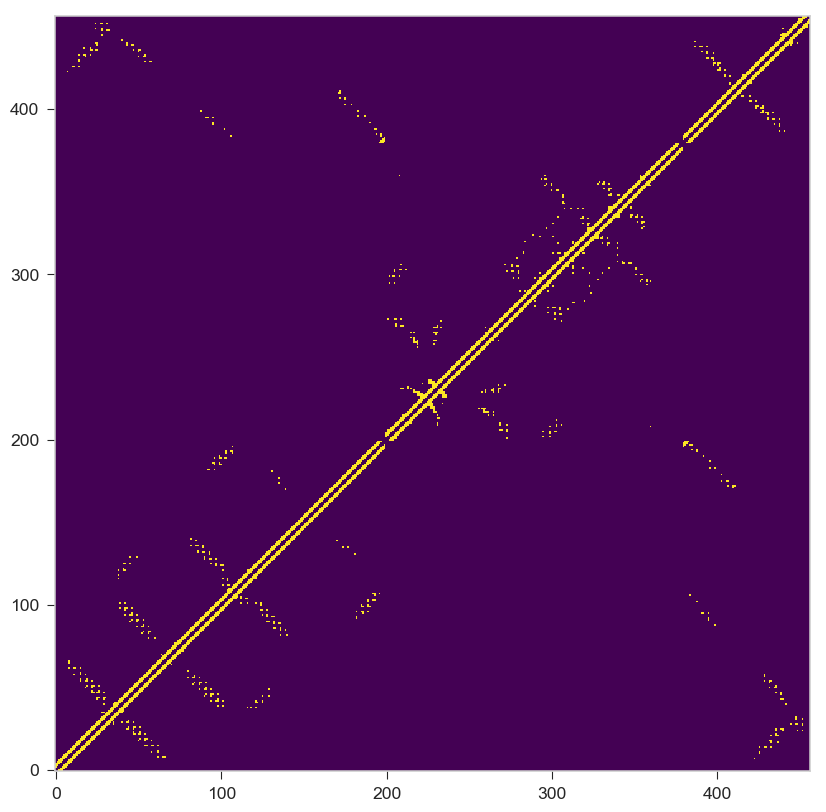

In [123]:
plt.imshow(contact_map, origin=0)

In [122]:
len(seq)

457

In [101]:
GlobularPart_index

array([166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
       244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
       257])

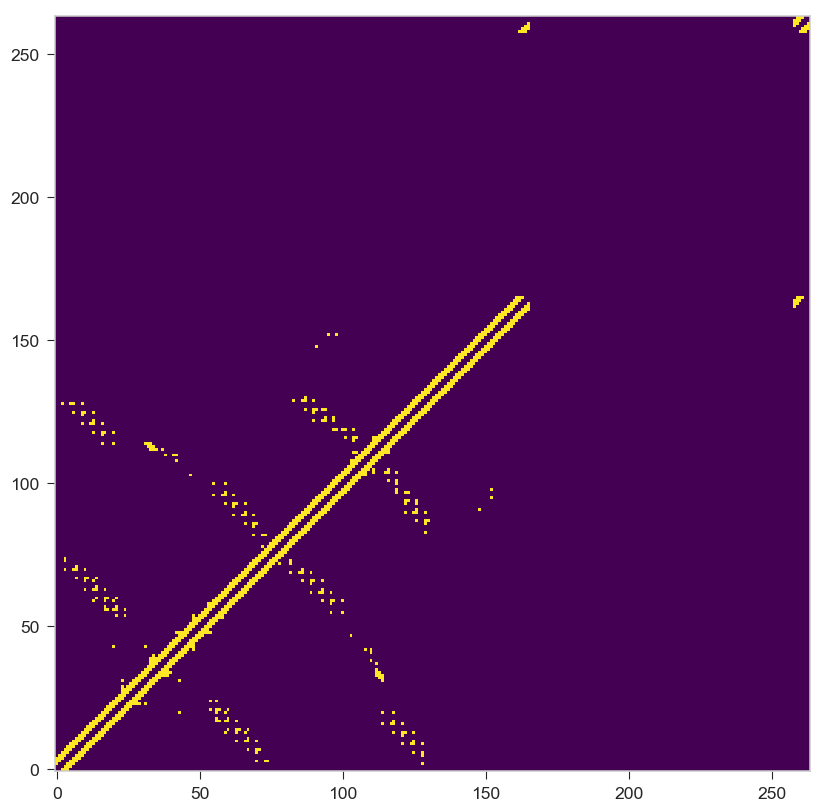

In [112]:
plt.imshow(contact_map, origin=0)

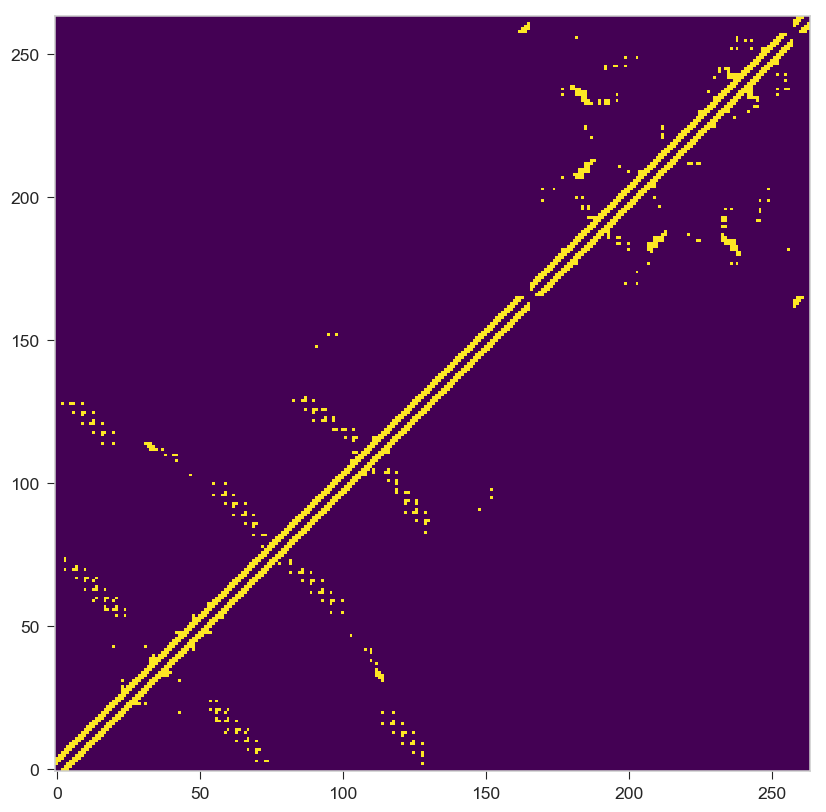

In [100]:
plt.imshow(contact_map, origin=0)

In [94]:
len(seq)

264

In [84]:
data.head()

,i,j,s,ss,p
0,167,169,0,8,0.993693
1,167,170,0,8,0.994291
2,167,171,0,8,0.989898
3,167,172,0,8,0.217831
4,167,173,0,8,0.039602


In [ ]:
fileLocation = f"{pre}/{pdb}_combined.deepmetapsicov.con"
with open(fileLocation, "w") as out:
    for index, d in MembranePart_data.iterrows():
    #     print(index)
        i = int(d["i"])
        j = int(d["j"])
        p = round(d["p"], 8)
        s = int(d["s"])
        ss = int(d["ss"])
        out.write(f"{i} {j} {s} {ss} {p}\n")
    for index, d in GlobularPart_data.iterrows():
    #     print(index)
        i = int(d["i"]) + len(seq_A)
        j = int(d["j"]) + len(seq_A)
        p = round(d["p"], 8)
        s = int(d["s"])
        ss = int(d["ss"])
        out.write(f"{i} {j} {s} {ss} {p}\n")
    out.write("END\n")

In [ ]:
getSeqFromFasta

In [ ]:
def get_contactFromDMP(fileLocation, n, threshold=0.2):
    a = np.zeros((n,n))
    c_list = []
    with open(fileLocation, "r") as f:
    #     for i in range(9):
    #         next(f)
        for line in f:
    #         print(line)
            try:
                i,j,_,_,_,p = line.split(" ")
    #             print(i,j,p)
                a[int(i)-1,int(j)-1] = float(p)
                a[int(j)-1,int(i)-1] = float(p)
                if float(p) > threshold:
                    c_list.append([int(i),int(j),float(p)])
            except Exception as e:
                print(e)
                pass
    return a, np.array(c_list)

def convertDMPToInput(pdbID, dmp_file, fasta_file, pre='/Users/weilu/opt/gremlin/'):
        # pdbID = "2xov_complete_2"
        # read in median distances for pairwise interactions (obtained from analysis of the pdb)
        directory=pre
        distancesCACB=pd.read_csv(directory+'CACBmediandist.dat', delim_whitespace=True, header=None)
        distancesCACA=pd.read_csv(directory+'CACAmediandist.dat', delim_whitespace=True, header=None)
        distancesCBCB=pd.read_csv(directory+'CBCBmediandist.dat', delim_whitespace=True, header=None)
        distancesCACB.columns = ['i', 'j', 'dist']
        distancesCACA.columns = ['i', 'j', 'dist']
        distancesCBCB.columns = ['i', 'j', 'dist']
        # if you want to filter the gremlin data, adjust the parameters below
        filter_threshold=0.5
        column=2

        seq = ""
        with open(fasta_file) as f:
            for line in f:
                if line[0] == ">":
                    continue
                seq += line.strip()
        # seq

        n=len(seq)
        _, dmp_pairs = get_contactFromDMP(dmp_file, n=n)

    #     print(n)
        rnative_matrixCACB=np.ones([n,n])*99
        rnative_matrixCACA=np.ones([n,n])*99
        rnative_matrixCBCB=np.ones([n,n])*99
        for pair in dmp_pairs:
            i=int(pair[0])
            j=int(pair[1])
            irestype=seq[i-1]
            jrestype=seq[j-1]
            if float(pair[column]) > filter_threshold:
                if sum((distancesCACB['i']==irestype)&(distancesCACB['j']==jrestype))>0: #check if pair is in correct order
                    well_centerCACB = distancesCACB[(distancesCACB['i']==irestype)&(distancesCACB['j']==jrestype)]['dist'].values[0]
                    well_centerCACA = distancesCACA[(distancesCACA['i']==irestype)&(distancesCACA['j']==jrestype)]['dist'].values[0]
                    well_centerCBCB = distancesCBCB[(distancesCBCB['i']==irestype)&(distancesCBCB['j']==jrestype)]['dist'].values[0]
                else:
                    well_centerCACB = distancesCACB[(distancesCACB['i']==jrestype)&(distancesCACB['j']==irestype)]['dist'].values[0]
                    well_centerCACA = distancesCACA[(distancesCACA['i']==jrestype)&(distancesCACA['j']==irestype)]['dist'].values[0]
                    well_centerCBCB = distancesCBCB[(distancesCBCB['i']==jrestype)&(distancesCBCB['j']==irestype)]['dist'].values[0]

                rnative_matrixCACB[i-1, j-1] = well_centerCACB
                rnative_matrixCACB[j-1, i-1] = well_centerCACB
                rnative_matrixCACA[i-1, j-1] = well_centerCACA
                rnative_matrixCACA[j-1, i-1] = well_centerCACA
                rnative_matrixCBCB[i-1, j-1] = well_centerCBCB
                rnative_matrixCBCB[j-1, i-1] = well_centerCBCB
        import matplotlib.pyplot as plt

        plt.imshow(rnative_matrixCACB, origin=0)
        # plt.show()
        fig = plt.gcf()
        directory = f"{pre}/protein/" + pdbID + "/DMP/"
        os.system("mkdir -p " + directory)
        figureDirectory = f"{directory}/contact.png"
        fig.savefig(figureDirectory)
        os.system(f"cp {dmp_file} {directory}")
        os.system(f"cp {fasta_file} {directory}")

        np.savetxt(directory + 'go_rnativeCACB.dat', rnative_matrixCACB, fmt='%10.5f')
        np.savetxt(directory + 'go_rnativeCACA.dat', rnative_matrixCACA, fmt='%10.5f')
        np.savetxt(directory + 'go_rnativeCBCB.dat', rnative_matrixCBCB, fmt='%10.5f')
